In [1]:
import open3d as o3d
import os
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
from PIL import Image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Showing a simple mesh

In [3]:
# Defining the path to the 3D model file.
mesh_path = '../assets/alex.obj'

# Reading the 3D model file as a 3D mesh using open3d.
mesh = o3d.io.read_triangle_mesh(mesh_path)

# Visualizing the mesh.
draw_geoms_list = [mesh]
o3d.visualization.draw_geometries(draw_geoms_list)

[Open3D WARNING] Unable to load file ../assets/alex.obj with ASSIMP
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


### Image to 3D

Depth image dtype: uint16
Depth image min/max values: 6 624


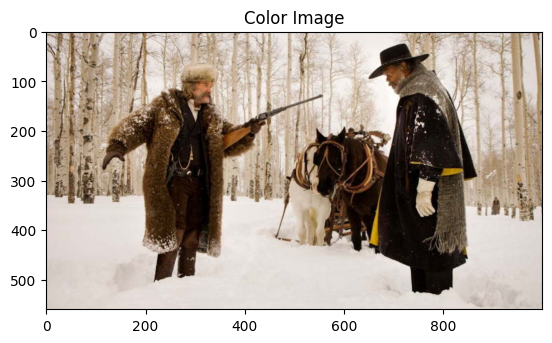

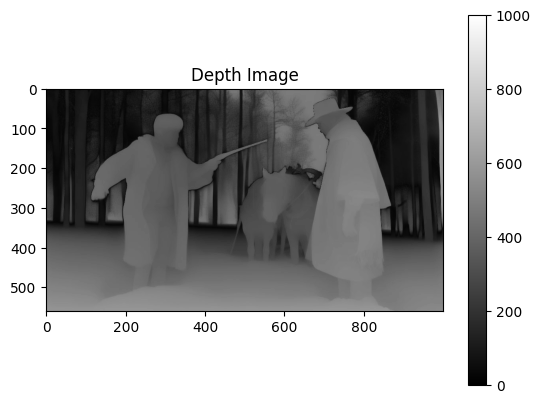

In [2]:
depth_img = cv2.imread("../assets/h82_depth.jpeg")
depth_img = cv2.cvtColor(depth_img, cv2.COLOR_BGR2RGB)
depth_img = cv2.cvtColor(depth_img, cv2.COLOR_RGB2GRAY)
depth_img = 255 - depth_img
#depth_img = cv2.add(depth_img, 100)
depth_img = depth_img.astype(np.uint16) * 3

print("Depth image dtype:", depth_img.dtype)
print("Depth image min/max values:", depth_img.min(), depth_img.max())

# Load color and depth images
color_raw = o3d.io.read_image("../assets/h82.jpeg")
depth_raw = o3d.geometry.Image(depth_img)

# Visualize the color image
plt.title("Color Image")
plt.imshow(np.asarray(color_raw))
plt.show()

# Visualize the depth image (scaled down for visualization)
plt.title("Depth Image")
plt.imshow(np.asarray(depth_raw),vmin=0, vmax=1000, cmap='gray')
plt.colorbar()
plt.show()

Using the create_from_color_and_depth method.

problem: Shifts the points towards a camera center

In [63]:
# Set up camera intrinsic parameters
# You may adjust these parameters or load them if you have specific calibration data
camera_intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=640,
    height=480,
    fx=500,  # Focal length x
    fy=500,  # Focal length y
    cx=300,  # Optical center x
    cy=300   # Optical center y
)

# Create RGBD image
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, 
    depth_raw, 
    depth_scale=1000.0,  # Convert depth values from mm to meters, adjust as necessary
    depth_trunc=3.0,     # Truncate depth values beyond 3 meters
    convert_rgb_to_intensity=False
)


# Generate point cloud from RGBD image
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    camera_intrinsics
)

#points = np.asarray(pcd.points)
#valid_points = points[np.all(points != 0, axis=1)]  # Filter out points at (0,0,0)
#pcd.points = o3d.utility.Vector3dVector(valid_points)

# Flip the point cloud (optional, depending on the coordinate system)
pcd.transform([[-1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1]])

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])

Just transform the points using the depth information and no perspective transformation

In [3]:
width = 1000
height = 560

# Convert depth to 3D points without perspective scaling
depth_scale = 1000.0  # Adjust according to your depth unit (e.g., depth image in millimeters)
depth = np.asarray(depth_img) / depth_scale

# Generate a 3D point grid
u, v = np.meshgrid(np.arange(width), np.arange(height))

# Convert to 3D coordinates
x = u #(u - 300) * depth / 500
y = v #(v - 300) * depth / 500
z = depth * 1000 # Maintain straight-line scaling without perspective adjustment

# Stack and filter valid points
points = np.dstack((x, y, z)).reshape(-1, 3)
valid_points = points[depth.reshape(-1) > 0]  # Remove zero-depth points

# Create an Open3D point cloud from the resulting 3D points
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(valid_points)

# Set the colors from the RGB image
rgb = np.asarray(color_raw).reshape(-1, 3) / 255.0  # Normalize to [0, 1]
pcd.colors = o3d.utility.Vector3dVector(rgb[depth.reshape(-1) > 0])

# Flip the point cloud (optional, depending on the coordinate system)
pcd.transform([[-1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1]])

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])